# Sentiment-Price Analysis for GOOG
### Task 3 - Predicting Price Moves with News Sentiment
**Author: Tadele Bizuye**

#### 1. Load & Aggregate GOOG Price Data

In [1]:
# === Import Libraries ===
import pandas as pd
from textblob import TextBlob

# === Step 1: Load GOOG Price Data ===
price_path = "C:/Users/TadeleBizuye/GOOG_historical_data.csv"
price_df = pd.read_csv(price_path, parse_dates=['Date'])

# Optional: Print columns to verify structure
print("GOOG Price Data Columns:", price_df.columns)

# Group to daily OHLC if data contains multiple rows per day
daily_df = price_df.groupby('Date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).reset_index()

GOOG Price Data Columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Dividends', 'Stock Splits'],
      dtype='object')


In [2]:
# === Step 2: Load Sentiment Data ===
sentiment_path = "C:/Users/TadeleBizuye/raw_analyst_ratings.csv"
sentiment_df = pd.read_csv(sentiment_path, parse_dates=['date'])

# Filter only for GOOG news
sentiment_df = sentiment_df[sentiment_df['stock'] == 'GOOG']

In [3]:
# === Step 3: Compute Sentiment Scores ===
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

sentiment_df['sentiment_score'] = sentiment_df['headline'].apply(get_sentiment)

In [4]:
# === Step 4: Aggregate Daily Sentiment Scores ===
daily_sentiment = sentiment_df.groupby('date').agg({
    'sentiment_score': 'mean'
}).reset_index().rename(columns={'date': 'Date'})

In [6]:
# === Step 5: Merge Sentiment with Daily Price Data ===

# Ensure datetime type for both Date columns
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

# Let pandas handle various date formats and timezones
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'], format='mixed', errors='coerce')

# Drop rows where date parsing failed
daily_sentiment = daily_sentiment.dropna(subset=['Date'])

# Merge on cleaned 'Date'
merged_df = pd.merge(daily_df, daily_sentiment, on='Date', how='left')
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(0)

# Preview result
print(merged_df[['Date', 'Close', 'sentiment_score']].tail())


           Date       Close  sentiment_score
5015 2024-07-24  174.369995              0.0
5016 2024-07-25  169.160004              0.0
5017 2024-07-26  168.679993              0.0
5018 2024-07-29  171.130005              0.0
5019 2024-07-30  171.860001              0.0


In [7]:
# === Step 6: Calculate Daily Returns ===
merged_df['daily_return'] = merged_df['Close'].pct_change()

In [8]:
# === Step 7: Correlation Analysis ===
correlation = merged_df[['sentiment_score', 'daily_return']].corr().iloc[0,1]
print(f"Pearson correlation between sentiment and returns: {correlation:.4f}")

Pearson correlation between sentiment and returns: 0.0177


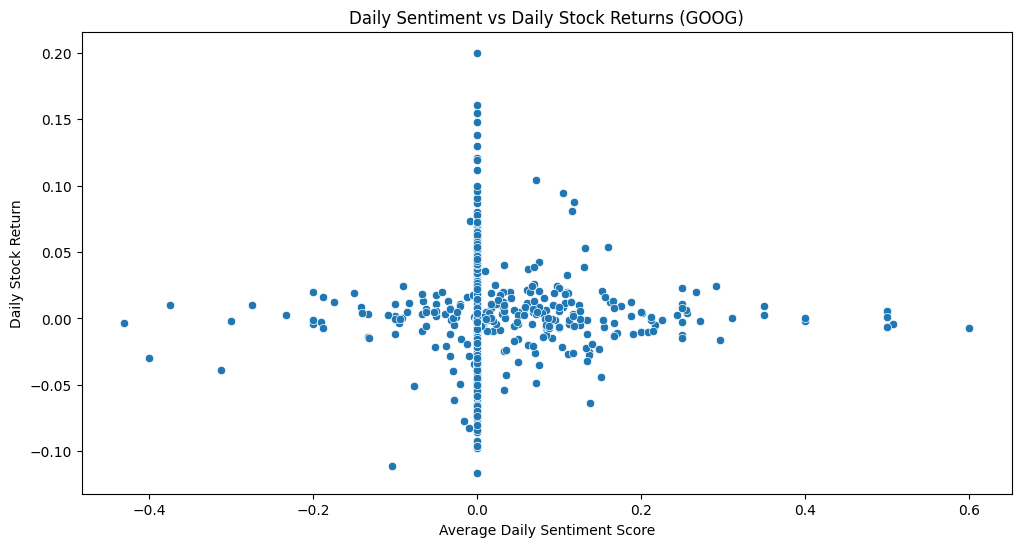

In [9]:
# === Step 8: Visualize ===
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.scatterplot(data=merged_df, x='sentiment_score', y='daily_return')
plt.title('Daily Sentiment vs Daily Stock Returns (GOOG)')
plt.xlabel('Average Daily Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.show()